# Code Challenge - Data - Unbalanced design

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def createData(threshold):
#     # create a new column for binarized (boolean) quality
    data['boolQuality'] = 0

    # note: use the following lines to avoid the warning message
    tmp = (data['quality']>threshold).astype(int)
    data['boolQuality'] = tmp

    # convert from pandas dataframe to tensor
    dataT  = torch.tensor( data[cols2zscore].values ).float()
    labels = torch.tensor( data['boolQuality'].values ).float()
    labels = labels[:,None] # transform to matrix

    # use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = torch.utils.data.TensorDataset(train_data,train_labels)
    test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

    # finally, translate into dataloader objects
    batchsize    = 64
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
    
    return train_loader, test_loader

In [4]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

In [7]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.leaky_relu( self.input(x) )
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    return self.output(x)

In [8]:
### a function that trains the model

# global parameter
numepochs = 500

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

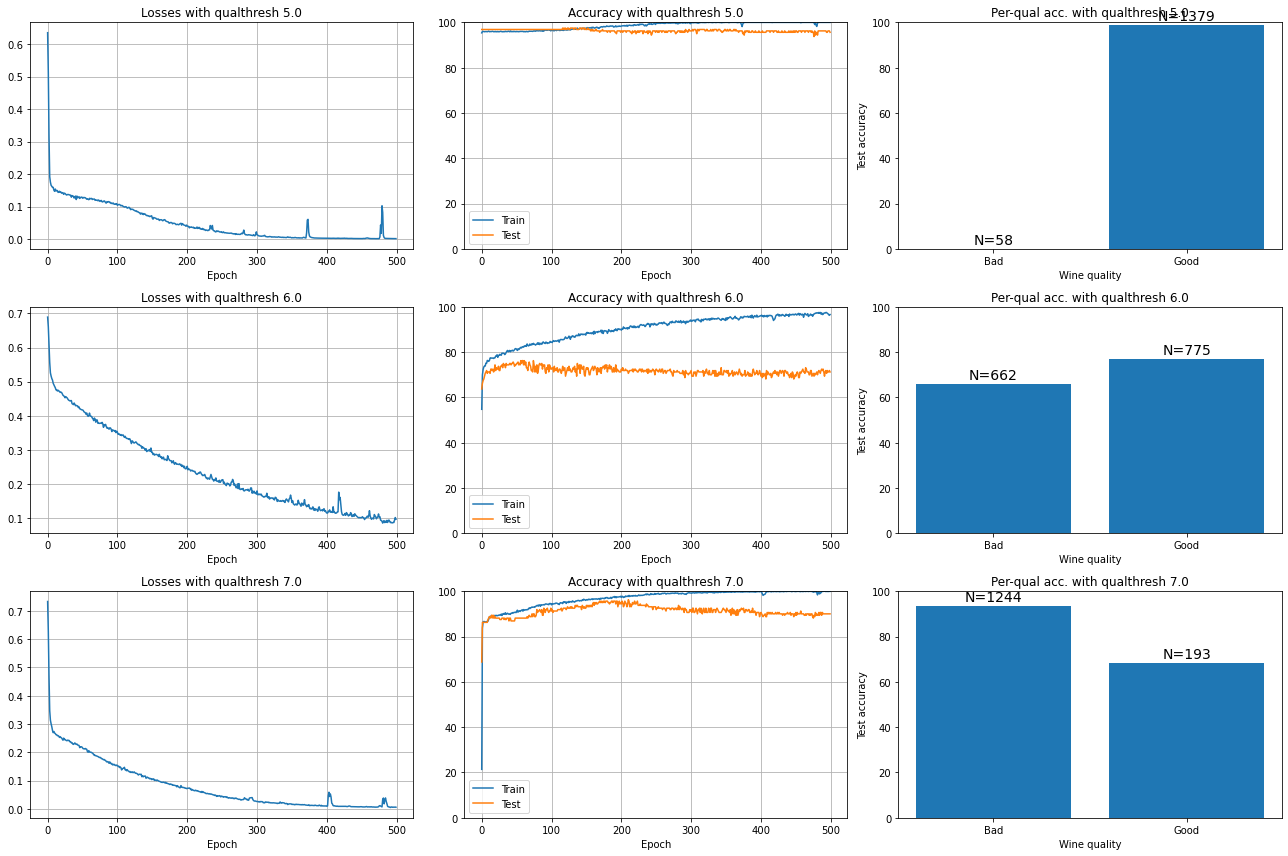

In [11]:
# note: this cell takes around 5 mins

# setup the figure
fig,ax = plt.subplots(3,3,figsize=(18,12))

# the quality thresholds
qualityThresholds = [4.5,5.5,6.5]


# loop over quality thresholds
for quali in range(len(qualityThresholds)):

  # create the data and model, and train it
  train_loader,test_loader = createData( qualityThresholds[quali] )
  winenet = ANNwine()
  trainAcc,testAcc,losses = trainTheModel()

  # compute accuracy per quality type
  X,y = next(iter(test_loader))
  itemAccuracy = ((winenet(X)>0) == y).float()
  perQualAcc  = [ 100*torch.mean(itemAccuracy[y==0]) ,
                  100*torch.mean(itemAccuracy[y==1]) ]


  # plot losses
  ax[quali,0].plot(losses)
  ax[quali,0].set_title('Losses with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,0].set_xlabel('Epoch')
  ax[quali,0].grid()

  # plot overall accuracy
  ax[quali,1].plot(trainAcc,label='Train')
  ax[quali,1].plot(testAcc,label='Test')
  ax[quali,1].set_title('Accuracy with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,1].legend()
  ax[quali,1].set_xlabel('Epoch')
  ax[quali,1].set_ylim([0,100])
  ax[quali,1].grid()

  # plot the per-quality accuracy
  bh = ax[quali,2].bar(['Bad','Good'],perQualAcc)
  ax[quali,2].set_ylim([0,100])
  ax[quali,2].set_xlabel('Wine quality')
  ax[quali,2].set_ylabel('Test accuracy')
  ax[quali,2].set_title('Per-qual acc. with qualthresh ' + str(qualityThresholds[quali]+.5))

  # print the counts on top of each bar
  for i,r in enumerate(bh):
    N = torch.sum(train_loader.dataset.tensors[1]==i).item()
    ax[quali,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)


plt.tight_layout()
plt.show()

# Code Challenge - Weight variance inits

Initialize the weights with Gaussian random numbers with std b/w 0.0001 and 10 in 25 logarithmic steps

## Model functions and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

### Splitting the data into train and test, and loading

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [7]:
def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.Adam(net.parameters(), lr=.01)
    
    return net, lossfn, optim

# function to train the model

def trainModel(net, lossfn, optim):
    
    nEp = 10
#     net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
                
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses

In [10]:
# experiment

std = np.logspace(np.log10(.0001), np.log10(10), 25)

nBins = 80 # number of histogram bins

accRes = np.zeros(len(std))
histData = np.zeros((len(std), 2, nBins))

for idx, sd in enumerate(std):
    
    net, lossfn, optim = createMNISTNet()
    
    for p in net.named_parameters():
        p[1].data = torch.randn_like(p[1].data) * sd
        
    net, trainAcc, testAcc, losses = trainModel(net, lossfn, optim)
    
    accRes[idx] = np.mean(testAcc[-3:])
    
    # collect all parameters into one vector and compute its histogram
    tmpparams = np.array([])
    for p in net.named_parameters():
        tmpparams = np.concatenate( (tmpparams,p[1].data.numpy().flatten()),axis=0 )

    # now compute their histogram
    y,x = np.histogram(tmpparams,nBins)
    histData[idx,0,:] = (x[1:]+x[:-1])/2
    histData[idx,1,:] = y

    # status report
    print(f'Finished {idx+1}/{len(std)}. Model accuracy was {accRes[idx]:.2f}%.')

Finished 1/25. Model accuracy was 93.28%.
Finished 2/25. Model accuracy was 93.88%.
Finished 3/25. Model accuracy was 91.97%.
Finished 4/25. Model accuracy was 93.05%.
Finished 5/25. Model accuracy was 94.37%.
Finished 6/25. Model accuracy was 92.08%.
Finished 7/25. Model accuracy was 93.90%.
Finished 8/25. Model accuracy was 93.23%.
Finished 9/25. Model accuracy was 93.40%.
Finished 10/25. Model accuracy was 94.03%.
Finished 11/25. Model accuracy was 94.23%.
Finished 12/25. Model accuracy was 95.05%.
Finished 13/25. Model accuracy was 94.97%.
Finished 14/25. Model accuracy was 94.45%.
Finished 15/25. Model accuracy was 94.78%.
Finished 16/25. Model accuracy was 94.40%.
Finished 17/25. Model accuracy was 95.33%.
Finished 18/25. Model accuracy was 94.40%.
Finished 19/25. Model accuracy was 93.15%.
Finished 20/25. Model accuracy was 75.10%.
Finished 21/25. Model accuracy was 25.27%.
Finished 22/25. Model accuracy was 10.80%.
Finished 23/25. Model accuracy was 11.50%.
Finished 24/25. Mode

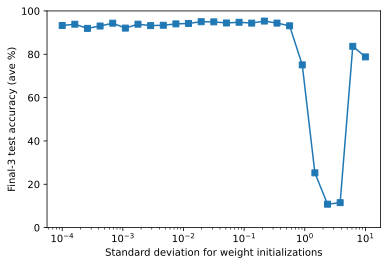

In [18]:
# Show the results!
plt.plot(std,accRes,'s-')
plt.xlabel('Standard deviation for weight initializations')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.xscale('log')
plt.ylim([00,100])
plt.show()

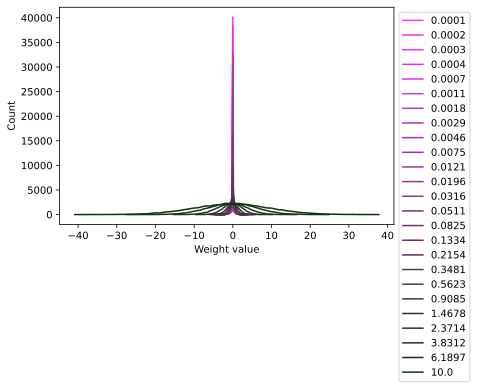

In [16]:
# show the weights distributions

for i in range(len(std)):
    plt.plot(histData[i,0,:],histData[i,1,:],color=[1-i/len(std),.2,1-i/len(std)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(std,4),bbox_to_anchor=(1,1),loc='upper left')
# plt.xlim([-1,1])
plt.show()

# Code Challenge - Xavier and Kaiming

Testing initialization of weights using Xavier and Kaiming on Wine-quality dataset

In [3]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import warnings
warnings.filterwarnings('ignore')

# Import and process the data

# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [45]:
# Now for the DL part

# create a class for the model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11,16)

        ### hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        ### output layer
        self.output = nn.Linear(32,1)

    # forward pass
    def forward(self,x):
        x = F.relu( self.input(x) )
        x = F.relu( self.fc1(x) )
        x = F.relu( self.fc2(x) )
        return self.output(x)

# A function to train the model

# global parameter
numepochs = 600

def trainTheModel(model):

    # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=.01)

    # initialize losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

        # forward pass and loss
            yHat = model(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = model(X)
        testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    # function output
    return trainAcc,testAcc,losses

In [46]:
# Kaiming initialization (default is Kaiming uniform with 'leaky_relu' mode)
winenet_kaiming = ANNwine()

for i in winenet_kaiming.named_parameters():
    if 'weight' in i[0]:
        nn.init.kaiming_uniform_(i[1].data, nonlinearity='relu')
        
trainAcc_K,testAcc_K,losses_K = trainTheModel(winenet_kaiming) 

In [47]:
# xavier initialization

winenet_xavier = ANNwine()

for p in winenet_xavier.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

trainAcc_X,testAcc_X,losses_X = trainTheModel(winenet_xavier) 

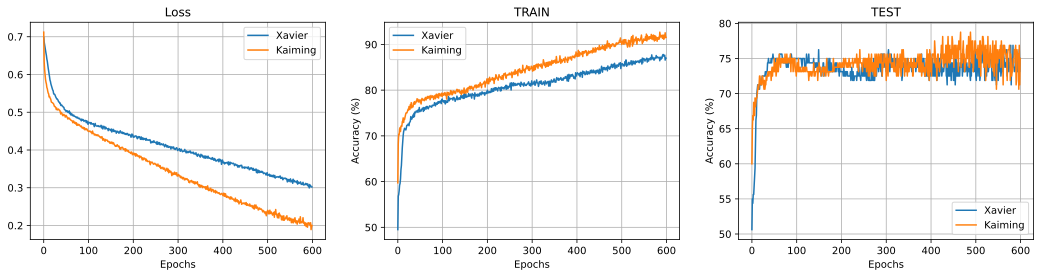

In [48]:
# plot the results

fig,ax = plt.subplots(1,3,figsize=(18,4))

# losses
ax[0].plot(losses_X,label='Xavier')
ax[0].plot(losses_K,label='Kaiming')
ax[0].set_title('Loss')

# train accuracy
ax[1].plot(trainAcc_X,label='Xavier')
ax[1].plot(trainAcc_K,label='Kaiming')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('TRAIN')

# test accuracy
ax[2].plot(testAcc_X,label='Xavier')
ax[2].plot(testAcc_K,label='Kaiming')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title('TEST')

for i in range(3):
    ax[i].legend()
    ax[i].grid('on')
    ax[i].set_xlabel('Epochs')


plt.show()

In [49]:
# Number of experiment iterations (note: ~1 min/iteration)
numExps = 10


# dimensions of results:
#  1 - experiment run
#  2 - metric (loss/train/test)
#  3 - weight init (X/K)
results = np.zeros( (numExps,3,2) )


for expi in range(numExps):

    ### XAVIER
    # create a model and change the weights
    winenet_xavier = ANNwine()
    for p in winenet_xavier.named_parameters():
        if 'weight' in p[0]:
            nn.init.xavier_normal_(p[1].data)

    # train the model and record its output
    trainAcc_X,testAcc_X,losses_X = trainTheModel(winenet_xavier)


    ### KAIMING
    # create a model and change the weights
    winenet_kaiming = ANNwine()
    for p in winenet_kaiming.named_parameters():
        if 'weight' in p[0]:
            nn.init.kaiming_uniform_(p[1].data,nonlinearity='relu')

    # train the model and record its output
    trainAcc_K,testAcc_K,losses_K = trainTheModel(winenet_kaiming)


    ### collect the results!
    results[expi,0,0] = torch.mean(losses_X[-5:]).item()
    results[expi,0,1] = torch.mean(losses_K[-5:]).item()

    results[expi,1,0] = np.mean(trainAcc_X[-5:])
    results[expi,1,1] = np.mean(trainAcc_K[-5:])

    results[expi,2,0] = np.mean(testAcc_X[-5:])
    results[expi,2,1] = np.mean(testAcc_K[-5:])


    # a little update message...
    print(f'Finished run {expi}/{numExps}')

Finished run 0/10
Finished run 1/10
Finished run 2/10
Finished run 3/10
Finished run 4/10
Finished run 5/10
Finished run 6/10
Finished run 7/10
Finished run 8/10
Finished run 9/10


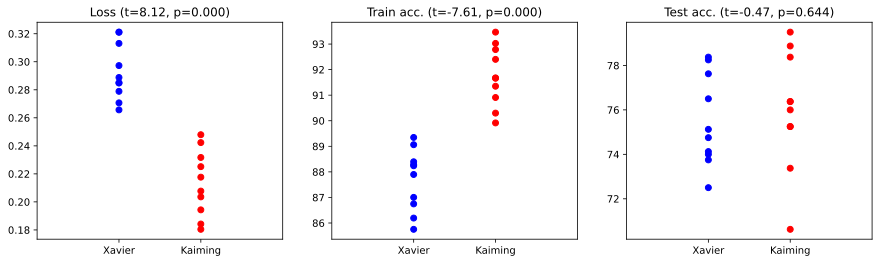

In [50]:
# And plot the results
fig,ax = plt.subplots(1,3,figsize=(15,4))

# plot titles
metric = ['Loss','Train acc.','Test acc.']

for i in range(3):
  
    # plot the results
    ax[i].plot(np.zeros(numExps),results[:,i,0],'bo')
    ax[i].plot(np.ones(numExps),results[:,i,1],'ro')

    # run a t-test to formalize the comparison
    t,p = stats.ttest_ind(results[:,i,0],results[:,i,1])
    title = '%s (t=%.2f, p=%.3f)' %(metric[i],t,p)


    # make the plot look a bit nicer
    ax[i].set_xlim([-1,2])
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(['Xavier','Kaiming'])
    ax[i].set_title(title)

plt.show()

# Code Challenge - Identically random weights

In [1]:
import numpy as np
import torch
import torch.nn as nn
import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

template = nn.Sequential(
    nn.Linear(2, 8),
    nn.Linear(8, 1),
    nn.Linear(1, 1)
)

/tmp/ipykernel_27200/799517836.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# no seed
net_noseed = copy.deepcopy(template)

# applying xavier initialization
for i in net_noseed.named_parameters():
    if 'weight' in i[0]:
        nn.init.xavier_normal_(i[1].data)

#same seed as rs1b
torch.manual_seed(5)
net_rs1a = copy.deepcopy(template)

for i in net_rs1a.named_parameters():
    if 'weight' in i[0]:
        nn.init.xavier_normal_(i[1].data)

# different seed from rs1a and rs1b.
torch.manual_seed(10)
net_rs2 = copy.deepcopy(template)

for i in net_rs2.named_parameters():
    if 'weight' in i[0]:
        nn.init.xavier_normal_(i[1].data)

# same seed as rs1b
torch.manual_seed(5)
net_rs1b = copy.deepcopy(template)

for i in net_rs1b.named_parameters():
    if 'weight' in i[0]:
        nn.init.xavier_normal_(i[1].data)

In [3]:
for i,j in zip(net_rs1b.named_parameters(), net_rs1a.named_parameters()):
    print(i[1].data == j[1].data)

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])
tensor([True, True, True, True, True, True, True, True])
tensor([[True, True, True, True, True, True, True, True]])
tensor([True])
tensor([[True]])
tensor([True])


In [4]:
for i,j in zip(net_rs1b.named_parameters(), net_rs2.named_parameters()):
    print(i[1].data == j[1].data)

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])
tensor([True, True, True, True, True, True, True, True])
tensor([[False, False, False, False, False, False, False, False]])
tensor([True])
tensor([[False]])
tensor([True])


In [5]:
for i,j in zip(net_rs1b.named_parameters(), net_noseed.named_parameters()):
    print(i[1].data == j[1].data)

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])
tensor([True, True, True, True, True, True, True, True])
tensor([[False, False, False, False, False, False, False, False]])
tensor([True])
tensor([[False]])
tensor([True])


In [6]:
for i,j in zip(net_noseed.named_parameters(), net_rs2.named_parameters()):
    print(i[1].data == j[1].data)

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])
tensor([True, True, True, True, True, True, True, True])
tensor([[False, False, False, False, False, False, False, False]])
tensor([True])
tensor([[False]])
tensor([True])


In [7]:
# initialize empty arrays
w_ns = np.array([])
w_1a = np.array([])
w_2  = np.array([])
w_1b = np.array([])

# loop over layers in the models
for i in range(3):

    # extract the vectorized weights matrices
    w_ns = np.append(w_ns,net_noseed[i].weight.view(-1).detach().numpy())
    w_1a = np.append(w_1a,  net_rs1a[i].weight.view(-1).detach().numpy())
    w_2  = np.append(w_2 ,   net_rs2[i].weight.view(-1).detach().numpy())
    w_1b = np.append(w_1b,  net_rs1b[i].weight.view(-1).detach().numpy())

# check the vector
w_ns

array([-0.23361316,  0.17781036, -0.13213041, -0.22223687,  0.24117723,
        0.70749736,  0.04957261,  0.2629599 ,  0.74361342, -0.38840008,
       -0.0602583 ,  0.09962492, -0.520715  ,  0.32349589,  0.80624831,
        0.23955594,  0.68648088, -1.14847004,  0.46479902,  0.18182559,
       -0.63455617, -0.9702062 ,  0.57649046, -0.51478803,  0.11365063])

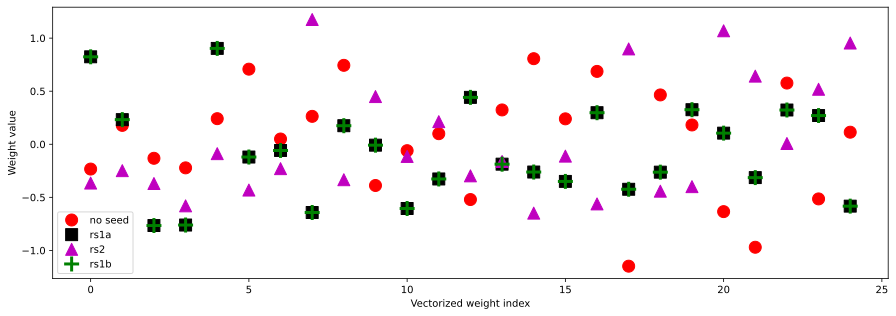

In [8]:
# plotting

fig = plt.figure(figsize=(15,5))

plt.plot(w_ns,'ro',markersize=12,label='no seed')
plt.plot(w_1a,'ks',markersize=12,label='rs1a')
plt.plot(w_2 ,'m^',markersize=12,label='rs2')
plt.plot(w_1b,'g+',markersize=15,label='rs1b',markeredgewidth=3)
plt.legend()
plt.xlabel('Vectorized weight index')
plt.ylabel('Weight value')

plt.show()